In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/mva/remotesensing

/content/drive/MyDrive/mva/remotesensing


In [3]:
!pip install geopandas rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 15.1 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import json

#### Loading an image using rasterio

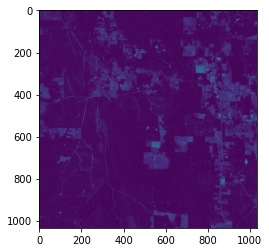

In [ ]:
# Get path to raster
path_to_raster = "data/sentinel-2/tx=37,ty=-332/20221010_B04.tif"
raster =  rasterio.open(path_to_raster)

# using the read function from rasterio you can read any bands contained in the raster
# Every raster a single-channelled in this cases study, you can then read the content of the
# raster as follows
red = raster.read(1)/10_000
plt.imshow(red)

#### Creating indices

A common processing step used in remote sensing is to work on indices rather than row data. This allows us to reduce the impact of the atmosphere and easily access meaningful features. Feel free to check https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/ to get more insights on the most common indices 

In [65]:
import cv2

In [74]:
def get_index(band1, band2):
    shape_1 = band1.shape
    shape_2 = band2.shape
    if np.sum(shape_1)>np.sum(shape_2):
        band2 = cv2.resize(band2, (shape_1[0], shape_1[1]))
    if np.sum(shape_2)>np.sum(shape_2):
        band1 = cv2.resize(band1, (shape_2[0], shape_2[1]))
    return (band1 - band2) / (band1 + band2 + 1e-5)


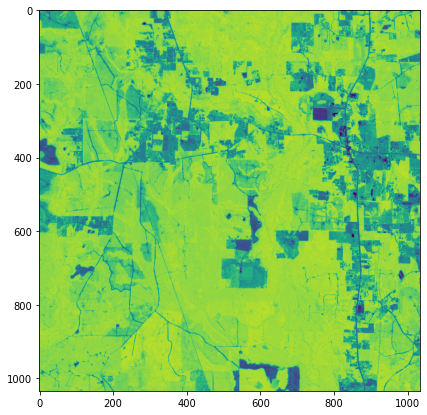

In [22]:
path_to_B04 = "data/sentinel-2/tx=37,ty=-332/20221010_B04.tif"
path_to_B08 = "data/sentinel-2/tx=37,ty=-332/20221010_B08.tif"
B04 = rasterio.open(path_to_B04).read(1)/10000
B08 = rasterio.open(path_to_B08).read(1)/10000
ndvi = get_index(B08, B04)
plt.figure(figsize=(7,7))
plt.imshow(ndvi, vmin=0, vmax=1)
plt.show()

#### Loading ground truth data

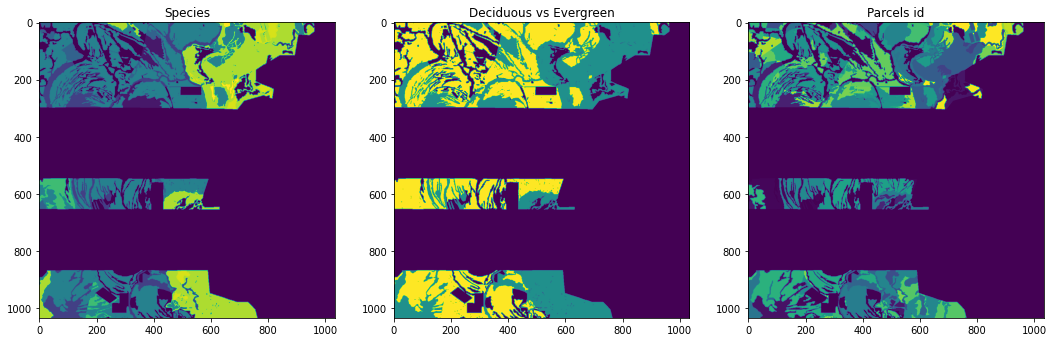

In [ ]:
# Get path to raster
path_to_raster = "data/ground_truth/tx=38,ty=-331.tif"
raster =  rasterio.open(path_to_raster)

species = raster.read(1)
deciduous_evergreen = raster.read(2)
parcel_id = raster.read(3)

# replacing nodata values
mask = (parcel_id==9999)
species[mask]=-1
deciduous_evergreen[mask]=-1
parcel_id[mask]=-1

fig, ax = plt.subplots(1,3, figsize=(18,7))
ax[0].imshow(species)
ax[0].set_title("Species")
ax[1].imshow(deciduous_evergreen)
ax[1].set_title("Deciduous vs Evergreen")
ax[2].imshow(parcel_id)
ax[2].set_title("Parcels id")
plt.show()

### Get relation between species id and names

In [ ]:
species_indexing = json.load(open("data/ground_truth/species_indexing.json"))
deciduous_evergreen_indexing = json.load(open("data/ground_truth/deciduous_evergreen_indexing.json"))
print(species_indexing)
print()
print(deciduous_evergreen_indexing)

{'6': 'pinus taeda', '2': 'nyssa sylvatica', '0': 'cypress', '13': 'quercus nigra', '14': 'quercus pagoda', '3': 'pinus echinata', '4': 'pinus elliottii', '10': 'quercus laurifolia', '16': 'quercus rubra', '1': 'liquidambar', '5': 'pinus palustris', '15': 'quercus phellos', '8': 'quercus acutissima', '12': 'quercus michauxii', '17': 'quercus shumardii', '11': 'quercus lyrata', '18': 'triadica sebifera', '9': 'quercus falcata', '7': 'pseudotsuga menziesii'}

{'1': 'evergreen', '0': 'deciduous'}


### Usefull links

* Sentinel-2 bands : 
    * https://gisgeography.com/sentinel-2-bands-combinations/
* Sentinel-2 indices : 
    * https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/
* Tree Species Classification with Multi-Temporal Sentinel-2 Data : 
    * https://www.mdpi.com/2072-4292/10/11/1794
* Rasterio documentation : 
    * https://rasterio.readthedocs.io/en/latest/index.html

In [63]:
import os, glob
import datetime
from collections import defaultdict
import re

In [64]:
from skimage.transform import resize

In [ ]:
def time_series(data_dir, ground_truth_dir, coordinates, agg_fn=np.mean):

  # store data in a dict (to be converted to pd.DataFrame later)
  data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: np.nan)))

  for coordinate in coordinates:
    parcel_ids = rasterio.open(os.path.join(ground_truth_dir, coordinate+'.tif')).read(3)

    for f in glob.iglob(os.path.join(data_dir, coordinate, '*_B*.tif')):
      img = rasterio.open(f).read(1)/10000

      # some bands have different sizes / pixel resolution (e.g. B11)
      for id in np.unique(parcel_ids):
        if parcel_ids.shape == img.shape:
          value = agg_fn(img[parcel_ids == id])
        else:
          value = agg_fn(resize(img, parcel_ids.shape)[parcel_ids == id])

        # extract band and date info from filename
        date, band = re.findall('[0-9]{8}_B[0-9]{2}', f)[0].split('_')
        date = datetime.datetime.strptime(date, '%Y%m%d').date()

        data[coordinate][(band,id)][date] = value
      
  return data

In [256]:
def simple_index(img_dict, bands):
  band1, band2 = (img_dict[bb] for bb in bands)
  shape_1 = band1.shape
  shape_2 = band2.shape
  if np.sum(shape_1)>np.sum(shape_2):
      band2 = cv2.resize(band2, (shape_1[0], shape_1[1]))
  if np.sum(shape_2)>np.sum(shape_2):
      band1 = cv2.resize(band1, (shape_2[0], shape_2[1]))
  return (band1 - band2) / (band1 + band2 + 1e-7)

def evi(img_dict, bands):
  B08, B04, B02 = (img_dict[bb] for bb in bands)
  return 2.5 * (B08 - B04) / (B08 + 6 * B04 - 7.5 * B02 + 1 + 1e-7)

def avi(img_dict, bands):
  B08, B04 = (img_dict[bb] for bb in bands)
  base = (B08 * (1 - B04)*(B08 - B04))
  return np.sign(base) * np.abs(base) ** (1/3)

In [257]:
indices = {
    'ndvi': (simple_index, ('B08', 'B04')),
    'gndvi': (simple_index, ('B08', 'B03')),
    'ndmi': (simple_index, ('B08', 'B11')),
    'evi': (evi, ('B08', 'B04', 'B02')),
    'avi': (avi, ('B08', 'B04')),
}

In [261]:
def index_time_series(data_dir, ground_truth_dir, coordinates, indices, agg_fn=np.mean):

  # store data in a dict (to be converted to pd.DataFrame later)
  data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: np.nan)))

  band_list = set(bb for b in indices.values() for bb in b[1])

  for coordinate in coordinates:
    parcel_ids = rasterio.open(os.path.join(ground_truth_dir, coordinate+'.tif')).read(3)

    for date in set(f.split('_')[-2].split('/')[-1] for f in glob.iglob(os.path.join(data_dir, coordinate, '*_B*.tif'))):

      # bands = {}
      # for band in band_list:
      #   bands[band] = rasterio.open(os.path.join(data_dir, coordinate, f'{date}_{band}.tif')).read(1)/10000
      bands = {
          band: rasterio.open(os.path.join(data_dir, coordinate, f'{date}_{band}.tif')).read(1)/10000
          for band in band_list
      }

      date = datetime.datetime.strptime(date, '%Y%m%d').date()

      for index, (fun, args) in indices.items():
        img = fun(bands, args)
        for id in np.unique(parcel_ids):
          value = agg_fn(img[parcel_ids == id])
          data[coordinate][(index,id)][date] = value
      
  return data

In [ ]:
data = time_series(
    data_dir='data/sentinel-2', 
    ground_truth_dir='data/ground_truth', 
    coordinates=[os.path.basename(d) for d in glob.iglob('data/sentinel-2/*')])

In [262]:
index_data = index_time_series(
    data_dir='data/sentinel-2', 
    ground_truth_dir='data/ground_truth', 
    coordinates=[os.path.basename(d) for d in glob.iglob('data/sentinel-2/*')],
    indices=indices,
)

In [94]:
import pickle

In [95]:
def default_to_regular(d):
  if isinstance(d, defaultdict):
    d = {k: default_to_regular(v) for k, v in d.items()}
  return d

In [270]:
with open('index_data.pkl', 'wb') as f:
  pickle.dump(default_to_regular(index_data), f)

To deal with later: some parcels may stretch over multiple tiffs:

In [ ]:
all_ids = []
for gt in glob.iglob('data/ground_truth/*.tif'):
  parcel_id = rasterio.open(gt).read(3)
  all_ids.extend(np.unique(parcel_id).tolist())

In [ ]:
len(all_ids)

548

In [ ]:
len(set(all_ids))

485

---

# Classes

In [100]:
def classes(ground_truth_dir, coordinates):

  species_dict = {}
  deciduous_evergreen_dict = {}
  
  for coordinate in coordinates:
    raster = rasterio.open(os.path.join(ground_truth_dir, coordinate+'.tif'))
    species = raster.read(1)
    deciduous_evergreen = raster.read(2)
    parcel_id = raster.read(3)

    for id in np.unique(parcel_id):
      species_dict[id] = np.unique(species[parcel_id == id]).item()
      deciduous_evergreen_dict[id] = np.unique(deciduous_evergreen[parcel_id == id]).item()
    
  return species_dict, deciduous_evergreen_dict

In [101]:
species_dict, deciduous_evergreen_dict = classes(
  ground_truth_dir='data/ground_truth', 
  coordinates=[os.path.basename(d) for d in glob.iglob('data/sentinel-2/*')])

---

# Feature extraction

In [98]:
with open('index_data.pkl', 'rb') as f:
  index_data = pickle.load(f)

In [120]:
index_df = pd.concat([pd.DataFrame(v, columns=pd.MultiIndex.from_tuples(v.keys(), names=["band", "parcel"])) for v in index_data.values()], axis='columns').sort_index()
index_df.head()

band            ndvi                                                    \
parcel          72        74        187       299       567       607    
2018-12-10  0.630195  0.752571  0.815299  0.653970  0.770760  0.833886   
2018-12-15       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-24  0.498841  0.723884  0.816700  0.520494  0.732127  0.857562   
2019-01-29  0.486212  0.730890  0.803278  0.507982  0.724090  0.843003   
2019-02-13  0.468721  0.688496  0.783122  0.478764  0.695802  0.825476   

band                                                ...      ndmi            \
parcel          641       796       797       834   ...      1568      1695   
2018-12-10  0.812571  0.596010  0.676413  0.697621  ...  0.345623  0.482466   
2018-12-15       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2019-01-24  0.804284  0.446060  0.583697  0.648433  ...  0.329339  0.474378   
2019-01-29  0.822185  0.432685  0.574209  0.647067  ...  0.334253  0.475590   
2019-02-13  0.764315  0.435184  0.551454  0.622295  ...  0.270134  0.415474   

band                                                                    \
parcel          1737      1742      1770      1805      1872      1909   
2018-12-10  0.003372  0.185063 -0.065511 -0.109837  0.230600  0.258426   
2018-12-15       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-24 -0.129271  0.109094 -0.110450 -0.108698  0.227938  0.252789   
2019-01-29 -0.101474  0.137766 -0.090246 -0.111965  0.227139  0.258954   
2019-02-13 -0.128164  0.046143 -0.147366 -0.131535  0.161602  0.191217   

band                            
parcel          2466      9999  
2018-12-10  0.330840  0.220868  
2018-12-15       NaN       NaN  
2019-01-24  0.330665  0.176247  
2019-01-29  0.342550  0.170259  
2019-02-13  0.286169  0.115821  

[5 rows x 1644 columns]

In [203]:
def winter_over_summer(df):

  winter = df.loc[[m in (12,1,2) for m in pd.DatetimeIndex(index_df.index).month]].mean()
  summer = df.loc[[m in  (6,7,8) for m in pd.DatetimeIndex(index_df.index).month]].mean()

  return winter / summer

In [204]:
def winter_diff_summer(df):

  winter = df.loc[[m in (12,1,2) for m in pd.DatetimeIndex(index_df.index).month]].mean()
  summer = df.loc[[m in  (6,7,8) for m in pd.DatetimeIndex(index_df.index).month]].mean()

  return summer - winter

In [217]:
def median_derivative(df):
  return df.diff().median()

In [215]:
def feature_extraction(df, feature_list):
  X = pd.concat([fun(df[index]) for (fun, index) in feature_list], axis=1)
  X.columns = [index + '_' + fun.__name__ for (fun, index) in feature_list]
  return X

In [218]:
# list of (function, index) tuples
features = [
    (median_derivative, 'ndvi'),
    (winter_over_summer, 'ndvi'),
    (winter_diff_summer, 'ndvi'),
    (np.std, 'ndvi'),
]

In [226]:
feature_extraction(index_df, features)

,ndvi_median_derivative,ndvi_winter_over_summer,ndvi_winter_diff_summer,ndvi_std
parcel,,,,
72,-0.011356,0.640802,0.297928,0.143071
74,-0.004431,0.839362,0.131255,0.074296
187,-0.008763,0.910312,0.072604,0.063592
299,-0.010752,0.654965,0.294173,0.143501
567,-0.008629,0.831135,0.141567,0.078166
...,...,...,...,...
1805,-0.006675,0.451090,0.433974,0.197992
1872,-0.004048,0.988052,0.009265,0.039433
1909,-0.005121,0.996304,0.002722,0.043477
